#### 참고
- model_selection은 모델 최적화에 필요한 다양한 툴 제공
- metrics는 모델 결과의 성능 지표 툴
- MinMaxScaler는 최댓값 최솟값을 이용해 입력 값 크기 조정

In [1]:
from sklearn import model_selection, metrics
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import matplotlib.pyplot as plt
import os

from keras import backend as K
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from keraspp import skeras, sfile

Using TensorFlow backend.


In [2]:
class CNN(Model):
    def __init__(model, nb_classes, in_shape=None):
        model.nb_classes = nb_classes
        model.in_shape = in_shape
        model.build_model() # 모델을 만들고
        super().__init__(model.x, model.y) # 부모 초기화 후
        model.compile() # 모델 컴파일 (뒤에서 overwrite함)
    
    def build_model(model):
        nb_classes = model.nb_classes
        in_shape = model.in_shape
        
        x = Input(in_shape)
        h = Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=in_shape)(x)
        h = Conv2D(64, (3, 3), activation='relu')(h)
        h = MaxPooling2D(pool_size=(2, 2))(h)
        h = Dropout(0.25)(h)
        h = Flatten()(h) # conv layer의 처리 결과를 fc layer로 보내기 위한 flatten
        z_cl = h # conv layer의 출력 별도 저장
        
        h = Dense(128, activation='relu')(h)
        h = Dropout(0.5)(h)
        z_fl = h # 출력 레이어로 나가기 전 fc layer의 출력 별도 저장
        
        y = Dense(nb_classes, activation='softmax', name='preds')(h)
        model.cl_part = Model(x, z_cl)
        model.fl_part = Model(x, z_fl)
        
        # 해당 모델을 만들 기 위해 입, 출력 멤버변수 초기화
        model.x, model.y = x, y
    
    def compile(model):
        Model.compile(model, loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [3]:
class DataSet():
    def __init__(self, X, y, nb_classes, scaling=True, test_size=0.2, random_state=0):
        self.X = X
        self.add_channels()
        X = self.X
        
        # split 함수가 섞어주는 것까지 해준다
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=random_state)
        
        X_train = X_train.astype('float32')
        X_test = X_test.astype('float32')
        
        if scaling:
            # scaling to have (0, 1) for each feature(pixel)
            scaler = MinMaxScaler()
            n = X_train.shape[0]
            X_train = scaler.fit_transform(X_train.reshape(n, -1)).reshape(X_train.shape)
            n = X_test.shape[0]
            X_test = scaler.transform(X_test.reshape(n, -1)).reshape(X_test.shape)
            self.scaler = scaler
            
        # one hot encoding
        Y_train = np_utils.to_categorical(y_train, nb_classes)
        Y_test = np_utils.to_categorical(y_test, nb_classes)
        
        self.X_train, self.X_test = X_train, X_test
        self.Y_train, self.Y_test = Y_train, Y_test
        self.y_train, self.y_test = y_train, y_test
        
    def add_channels(self):
        X = self.X
        
        if len(X.shape) == 3:
            N, img_rows, img_cols = X.shape
            
            if K.image_data_format() == 'channels_first':
                X = X.reshape(X.shape[0], 1, img_rows, img_cols) # 3으로 해야하는 것 아님?
                input_shape = (1, img_rows, img_cols)
            else:
                X = X.reshape(X.shape[0], img_rows, img_cols, 1)
                input_shape = (img_rows, img_cols, 1)
        else:
            input_shape = X.shape[1:] # channel is already included (개수, row, col, 차원) 가정하는 듯
        
        self.X = X
        self.input_shape = input_shape
                

In [4]:
class Machine():
    def __init__(self, X, y, nb_classes=2, fig=True):
        self.nb_classes = nb_classes
        self.set_data(X, y)
        self.set_model()
        self.fig = fig
    
    def set_data(self, X, y):
        nb_classes = self.nb_classes
        self.data = DataSet(X, y, nb_classes)
    
    def set_model(self):
        nb_classes = self.nb_classes
        data = self.data
        self.model = CNN(nb_classes=nb_classes, in_shape=data.input_shape)
    
    def fit(self, nb_epoch=10, batch_size=128, verbose=1):
        data = self.data
        model = self.model
        
        history = model.fit(data.X_train, data.Y_train,
                           batch_size=batch_size, epochs=nb_epoch,
                           verbose=verbose,
                           validation_data=(data.X_test, data.Y_test))
        return history
    
    def run(self, nb_epoch=10, batch_size=128, verbose=1):
        data = self.data
        model = self.model
        fig = self.fig
        
        history = self.fit(nb_epoch=nb_epoch, batch_size=batch_size, verbose=verbose)
        score = model.evaluate(data.X_test, data.Y_test, verbose=0)
        
        print('Confusion Matrix')
        Y_test_pred = model.predict(data.X_test, verbose=0)
        y_test_pred = np.argmax(Y_test_pred, axis=1)
        print(metrics.confusion_matrix(data.y_test, y_test_pred))
        
        print('Test score:', score[0])
        print('Test acc  :', score[1])
        
        suffix = sfile.unique_filename('datetime')
        foldname = 'output_' + suffix
        os.makedirs(foldname)
        skeras.save_history_history('history_history.npy', history.history, fold=foldname)
        model.save_weights(os.path.join(foldname, 'dl_model.h5'))
        print('Output result are saved in ', foldname)
        
        if fig:
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            skeras.plot_acc(history)
            plt.subplot(1, 2, 2)
            skeras.plot_loss(history)
            plt.show()
        
        self.history = history

#### 실제 코드에선 위에까지를 .py에 넣어놓고 밑에서 임포트해서 씀

In [5]:
from keras import datasets
import keras
assert keras.backend.image_data_format() == 'channels_last'

class MyMachine(Machine):
    def __init__(self):
        (X, y), (x_test, y_test) = datasets.cifar10.load_data()
        super().__init__(X, y, nb_classes=10)

In [6]:
def main():
    m = MyMachine()
    m.run()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 7s 170us/step - loss: 1.8296 - acc: 0.3407 - val_loss: 1.5288 - val_acc: 0.4401
Epoch 2/10
40000/40000 [==============================] - 4s 102us/step - loss: 1.4569 - acc: 0.4831 - val_loss: 1.2748 - val_acc: 0.5525
Epoch 3/10
40000/40000 [==============================] - 4s 104us/step - loss: 1.2960 - acc: 0.5398 - val_loss: 1.1874 - val_acc: 0.5809
Epoch 4/10
40000/40000 [==============================] - 4s 104us/step - loss: 1.1910 - acc: 0.5811 - val_loss: 1.1030 - val_acc: 0.6102
Epoch 5/10
40000/40000 [==============================] - 4s 110us/step - loss: 1.1186 - acc: 0.6091 - val_loss: 1.0405 - val_acc: 0.6321
Epoch 6/10
40000/40000 [=================

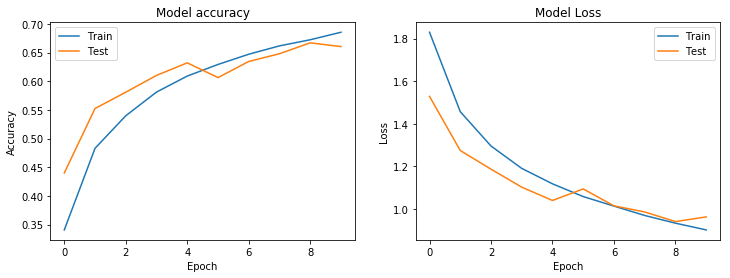

In [7]:
main()